In [1]:
import arviz as az 
import pymc3 as pm
import numpy as np
from matplotlib import pyplot as plt

<font color='red'> 
Exercise 7.3 </font>

 [Purpose: Using a multimodal prior with the Metropolis
algorithm, and seeing how chains can transition across modes or get stuck
within them.] In this exercise, you will see that the Metropolis algorithm operates
with multimodal distributions.

(A) Consider a prior distribution on coin bias that puts most credibility at 0.0, 0.5,
and 1.0, which we will formulate as p(θ) = (cos(4πθ) + 1) 2 /1.5.

(B) Make a plot of the prior. Hint: theta = seq(0,1,length=501) ; plot
(theta , (cos(4*pi*theta)+1) ˆ 2/1.5 )

(C) In the script BernMetrop.R , find the function definition that specifies the prior
distribution. Inside that function definition, comment out the line that assigns a beta
density to pTheta , and instead put in a trimodal prior like this:
#pTheta = dbeta( theta , 1 , 1 )
pTheta = (cos(4*pi*theta)+1)ˆ2/1.5
To have the Metropolis algorithm explore the prior, we give it empty data. Find the
line in the script that specifies the data and set myData = c() . Run the script, using a
proposal SD=0.2. Include the graphical output in your write-up. Does the histogram of
the trajectory look like the graph of the previous part of the exercise?

(D) Repeat the previous part but now with myData = c(0,1,1) . Include the
graphical output in your write-up. Does the posterior distribution make sense? Explain
why.

(E) Repeat the previous part but now with proposal SD=0.02. Include the graphical
output in your write-up. Does the posterior distribution make sense? Explain why not;
what has gone wrong? If we did not know from the previous part that this output was
unrepresentative of the true posterior, how could we try to check? Hint: See next part.

(F) Repeat the previous part but now with the initial position at 0.99: trajec-
tory[1] = 0.99 . In conjunction with the previous part, what does this result tell us?

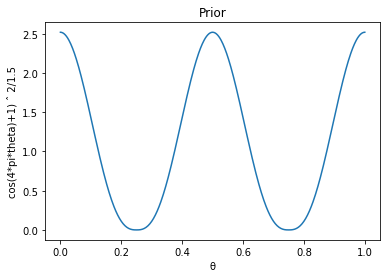

In [2]:
# (B)

import math

theta = np.linspace (0, 1, 501)

prior = []
for t in theta:
        prior.append(((math.cos(4 * math.pi * t) ) +1) ** (2/1.5))
    
    
fig, ax = plt.subplots()
ax.set_title("Prior")   
ax.plot(theta,prior)
ax.set_xlabel('θ') 
ax.set_ylabel('cos(4*pi*theta)+1) ˆ 2/1.5') 

plt.show()


Sequential sampling (1 chains in 1 job)
Metropolis: [thetaC]
Sampling chain 0, 0 divergences: 100%|██████████| 50500/50500 [00:08<00:00, 5835.09it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fd4ca0bd190>],
      dtype=object)

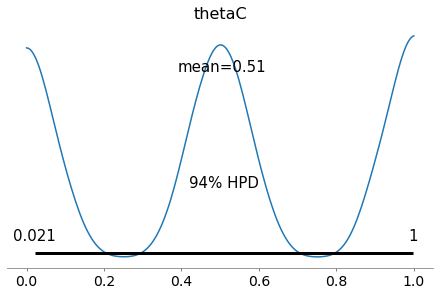

In [4]:
# C) 
import theano.tensor as T
# import math

def custom_prior(name='custom_prior'):
    def prior(θ):
        return (pm.math.cos(4*math.pi*θ) + 1)**2/1.5

    def bound(θ, lower=0, upper=1):
        return T.switch(T.lt(θ, lower), -np.inf, T.switch(T.gt(θ, upper), np.inf, θ))

    def logp(θ):
        return np.log(prior(bound(θ)))
    return pm.DensityDist(name=name, logp=logp)

    
with pm.Model() as modelC:
    theta = custom_prior(name="thetaC")
    traceC = pm.sample(
        50000, 
        step=pm.step_methods.metropolis.Metropolis(S=np.array([0.2])), 
        chains = 1,
        start = [{ "thetaC": 0.01 }],
        tune=500
    )

az.plot_posterior(traceC)

In [ ]:
# (D) Repeat the previous part but now with myData = c(0,1,1) . Include the graphical output in your write-up. 
# Does the posterior distribution make sense? Explain why. Using myData=c(0,1,1) and proposal SD=0.2:

with pm.Model() as modelD:
    D = np.concatenate([np.repeat(0,1), np.repeat(1,2)])
#     D = np.array([0,1,1]) # myData = c(0,1,1) 
    theta = custom_prior(name="theta")
    y = pm.Bernoulli(name="obs", p=theta, observed=D)
    traceD = pm.sample(
                50000,
                step=pm.step_methods.metropolis.Metropolis(S=np.array([0.2])),
                chains = 1, 
                start = [{ "theta": 0.01 }], # 1 starting point at 0.01. if 0 it will fuck up the sample
                discard_tuned_samples = True, # Show the burn-in prefix like in Fig. 7.10
                tune = 500
           )
    
ax = pm.traceplot(traceD)
ax[0,0].axis([0.0, 1.0, 0.0, 6.0])
ax[0,1].axis([0,1000,0.0, 1.0,]) # clip the trace plot (to the right, to show the entire development better)

pm.plot_posterior(traceD)
# az.plot_posterior(trace, kind='hist')
#     pm.autocorrplot(sample)
plt.show()
    
# The posterior distribution makes sense because it is a compromise between the trimodal prior
# and the gently peaked likelihood function of the small data set. The likelihood function peaks at
# 0.667 (i.e., 2/3), but is very broad, gently descending to 0 height at theta=0 and theta=1.
# Therefore the prior peaks at theta=0.5 and near theta=1.0 are “allowed” by the data, but the
# prior peak near theta=0.0 is relatively unlikely given the data. (The HDI as marked is irrelevant
# and potentially misleading because its algorithm assumes a unimodal distribution; see Ch. 25.)

In [ ]:
# (E) Repeat the previous part but now with proposal SD=0.02. Include the graphical output in your write-up. 
# Does the posterior distribution make sense? Explain why not; what has gone wrong? If we did not know from 
# the previous part that this output was unrepresentative of the true posterior, how could we try to check? 
# Hint: See next part.

with pm.Model() as modelE:
    D = np.concatenate([np.repeat(0,1), np.repeat(1,2)])
#     D = np.array([0,1,1]) # myData = c(0,1,1) 
#     D = [0,1,1]
    theta = custom_prior(name="theta")
    y = pm.Bernoulli(name="obs", p=theta, observed=D)
    traceE = pm.sample(
                50000, # even with 5000000
                step=pm.step_methods.metropolis.Metropolis(S=np.array([0.02])),
                chains = 1, 
                start = [{ "theta": 0.01 }], # 1 starting point at 0.01. if 0 it will fuck up the sample
                discard_tuned_samples = True, # Show the burn-in prefix like in Fig. 7.10
                tune = 500
           )
    
ax = pm.traceplot(traceE)
ax[0,0].axis([0.0, 1.0, 0.0, 6.0])
ax[0,1].axis([0,1000,0.0, 1.0,]) # clip the trace plot (to the right, to show the entire development better)

pm.plot_posterior(traceE)
# az.plot_posterior(trace, kind='hist')
#     pm.autocorrplot(sample)
plt.show()

# If we did not know from other considerations that this was an anomalous result, we could start
# several chains at different starting positions and check that they all converged to the same
# region of parameter space. (See the next part of the exercise for an example of starting at a
# different point in parameter space.)

In [ ]:
# (F) Repeat the previous part but now with the initial position at 0.99: trajec- tory[1] = 0.99 .
# In conjunction with the previous part, what does this result tell us?

with pm.Model() as modelF:
    D = np.concatenate([np.repeat(0,1), np.repeat(1,2)])
#     D = np.array([0,1,1]) # myData = c(0,1,1) 
    theta = custom_prior(name="theta")
    y = pm.Bernoulli(name="obs", p=theta, observed=D)
    traceF = pm.sample(
                50000,  # Specify the length of the trajectory, i.e., the number of jumps to try.
                step=pm.step_methods.metropolis.Metropolis(S=np.array([0.02])),
                chains = 1, 
                start = [{ "theta": 0.99 }], # 1 starting point at 0.01. if 0 it will fuck up the sample
                discard_tuned_samples = True, # Show the burn-in prefix like in Fig. 7.10
                tune = 500
           )
    
ax = pm.traceplot(traceF)
ax[0,0].axis([0.0, 1.0, 0.0, 6.0])
ax[0,1].axis([0,1000,0.0, 1.0,]) # clip the trace plot (to the right, to show the entire development better)

pm.plot_posterior(traceF)
# az.plot_posterior(trace, kind='hist')
#     pm.autocorrplot(sample)
plt.show()

# If we started chains at several different values
# of theta, we would notice that they do not converge to the same region of parameter space,
# which would be a sign that the results are not fully representative of the posterior, and we
# would need to adjust the MCMC sampler.